<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification

'rm' is not recognized as an internal or external command,
operable program or batch file.


c:\Users\nguye\Downloads\Vietnamese-Review-Classification\Vietnamese-Review-Classification


fatal: destination path 'Vietnamese-Review-Classification' already exists and is not an empty directory.


In [2]:
!sudo apt-get install python3.7
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

'sudo' is not recognized as an internal or external command,
operable program or batch file.


  Using cached https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz (233.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [3]:
# !git pull origin master


Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


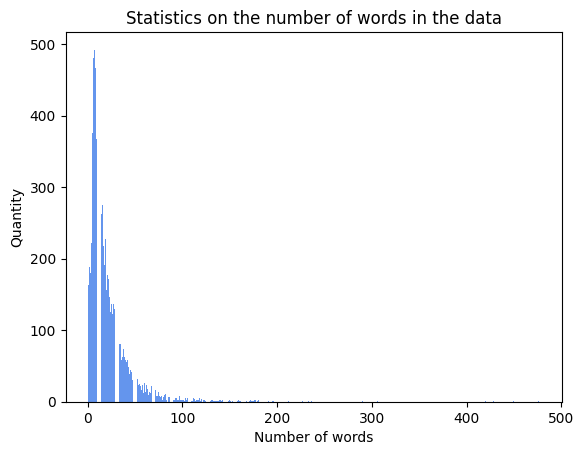

In [4]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [5]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open("./models/review_tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


In [7]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras import regularizers

# Build RNN model
model = Sequential()
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len)
model.add(embedding_layer)

# Sửa tên biến cho lớp nhúng
old_embedding_name = embedding_layer.weights[0].name  # Lấy tên của biến trong lớp nhúng
new_embedding_name = 'embedding/embeddings:0'
embedding_layer.weights[0]._name = new_embedding_name
model.add(LSTM(units=64))
model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=8, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=3, activation='softmax', kernel_regularizer=regularizers.L2(0.01)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(x_train_pad, y_train_one_hot, batch_size=50, epochs=10, validation_data=(x_val_pad, y_val_one_hot))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          764800    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                

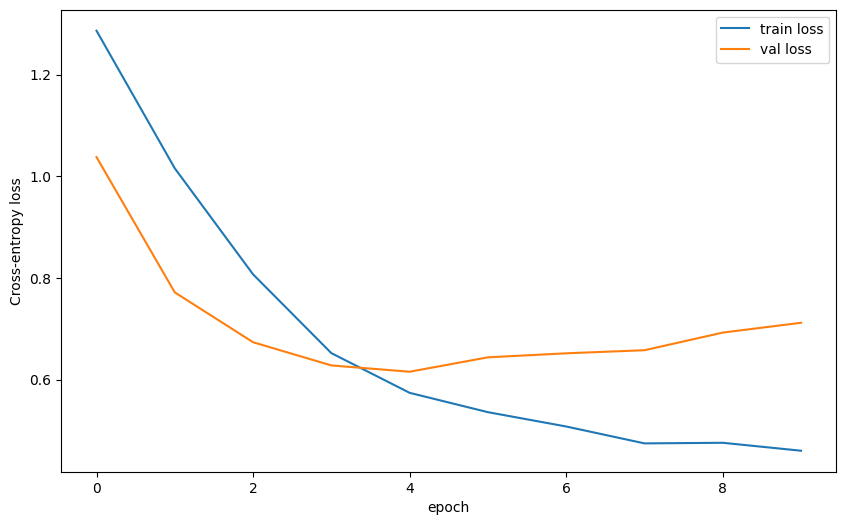

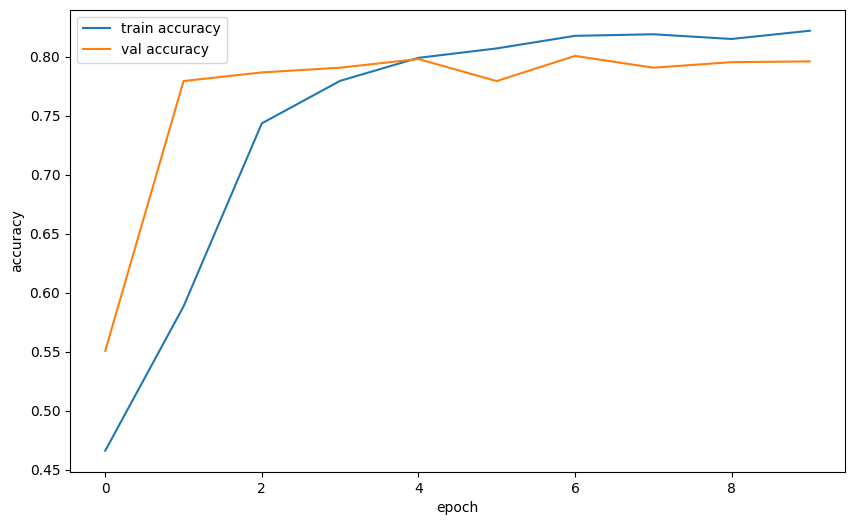

In [9]:
from utils.plotter import plot_history_model

plot_history_model(history)

In [10]:
from sklearn.metrics import confusion_matrix

score, acc = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 1s - loss: 0.7002 - accuracy: 0.7873 - 980ms/epoch - 10ms/step
Test score: 0.7001920342445374
Test accuracy: 0.7873333096504211
100/100 [==============================] - 1s 7ms/step
Confusion Matrix:
[[745  56   0]
 [ 67 436   0]
 [ 69 127   0]]


In [11]:
model.save('C:/Users/nguye/Downloads/Vietnamese-Review-Classification/models/review_model.keras')